# Assignment: Celeberity Classification using PCA Dimensionality Reduction

### Name: SOLUTION

### Due Date: XXXX


### Import Libraries


Import the libraries you'll need for this lab. (Hint: 


In [27]:
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

##1. Data preparation


### 1.1. Load data


Read the celebrity_data.npy file in using numpy's "load" function. Make sure to set **allow_pickle** to true. 

If you get an error saying "```data is truncated```", your download is likely corrupted. Try redownloading the data and try again.

In [28]:
from numpy import load
import numpy as np

data = load('celebrity_data.npy', allow_pickle=True)

### 1.2. Pre-Processing The Data

Right now, our image data is stored in 2 tuples: (images, labels). We'd like to have our data seperated - one array containing images in the shape ```(#imgs, height, width)``` and seperate array for their labels. Below is the preprocessing code. 

In [29]:
# Initialize array
faces = []
labels = []

# Unzip images & labels
faces, labels = zip(*data)

faces = np.stack(faces)
labels = np.asarray(labels)

# Remove unecessary information on labels
for i in range(labels.shape[0]):
  labels[i] = labels[i].split('-cropped')[0]

# Get a reference to num_samples, height & width of each image
num_samples, h, w = faces.shape

### 1.3. Reshaping Image Data

In order to perform SVD on our image data, we need to represent ALL of our data into a single 2D matrix. Each column should represent a single image, with each row being a single pixel of that image. It should have shape of ```(num_images, pixels_per_img)``` 


In [30]:
# Hint: Look into the np.ravel function

flattened_faces = []
for i in range(faces.shape[0]):
  flattened_faces.append(np.ravel(faces[i]))
  
images = np.asarray(flattened_faces)
print(images.shape)

(1668, 6000)


## 2. Normalization

In order to apply PCA, we need to make sure our data is normalized. 

1. Compute the ```Average Face``` for each pixel from all celebrity images. Since each image is a column vector of our matrix, the mean of each *row* will be the average value of that particular pixel for *every* image.
2. Subtract out the resulting ```Average Face``` from all our training images.

We'll provide some helper functions to display some of the transformed images below!

In [31]:
## Helper functions for displaying faces

# For calling on matrix form of images (60 x 100)
def sample_results(images): 
  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].reshape(h, w), cmap='gray')
  plt.show()

# For calling on vectorized images (40000 x 1)
def sample_results_reshaped(images): 
  plt.figure(figsize=(10,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()

### 2.1 Computing Average Face

Compute the ```Average Face``` for each pixel from all celebrity images. Since each image is a column vector of our matrix, the mean of each *row* will be the average value of that particular pixel for *every* image. 

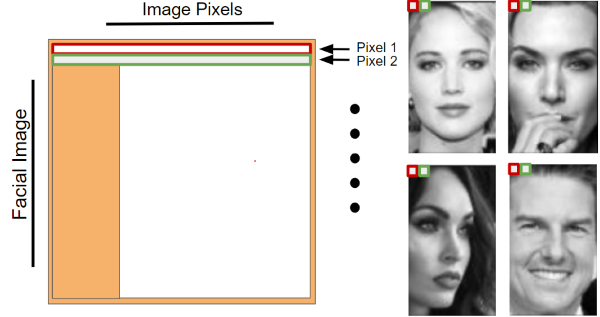

In [32]:
# TODO: Compute average face
avg_face = np.mean(images, axis=0)

As a sanity check, we'll plot the average image We'll also provide some helper functions to display batches of images

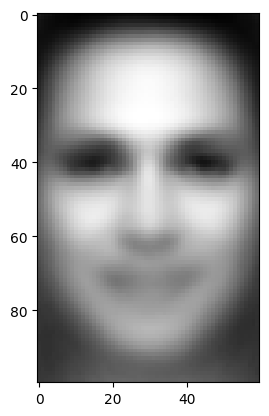

In [33]:
plt.imshow(avg_face.reshape(h, w), cmap="gray")

### 2.2 Applying Normalization

Subtract out the resulting ```Average Face``` from all our training images.




In [34]:
# TODO: Compute normalized faces for each face
normalized_images = images - avg_face

We'll plot a batch of faces from our original data & our normalized data as a sanity check.

~~~~ Original Faces ~~~~


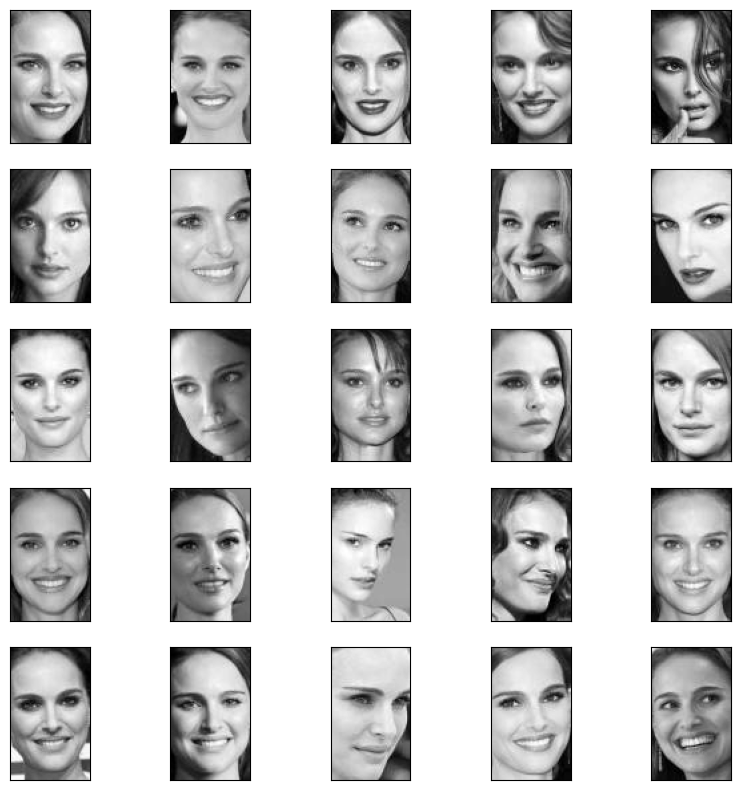

~~~~ Normalized Faces ~~~~


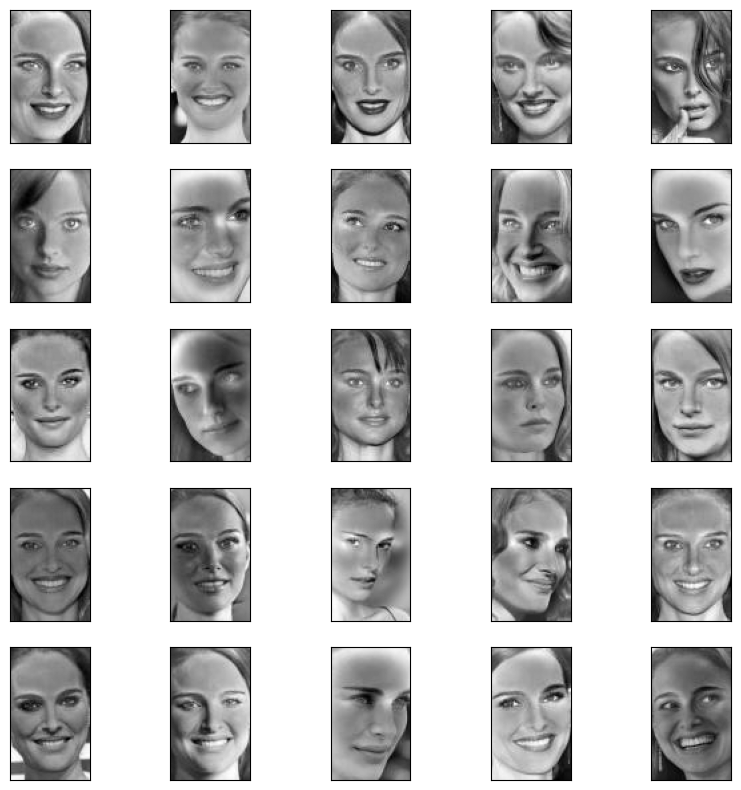

In [35]:
print("~~~~ Original Faces ~~~~")
sample_results(images)
print('~~~~ Normalized Faces ~~~~')
sample_results(normalized_images)

## 3. Apply PCA 

Now that all our data is normalized, we can go about computing the PCA dimension reduction of our images. 

1. First we compute the Singular Value Decomposition (SVD) of all facial images in our dataset. SVD breaks down the data into the form ```{U, S, Vt}```, where the product of each column of U, value of S & row of Vt encodes a defining characteristic of the total data. We call U & Vt, the left and right singular vectors of A and S the diagonal matrix of singular values.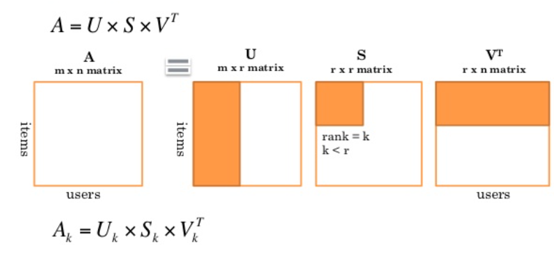 <br>The first k columns Uk, singular values Sk, and rows Vtk represent the k most important features of the image data. For example, the first few singular values and corresponding singular vectors may encode basic features of the faces, such as the overall brightness, contrast, and sharpness of the images. The middle singular values and corresponding singular vectors may encode more subtle features of the faces, like the shape of the eyes, nose, and mouth, and the overall shape and proportion of the face. 

2. Take the product of the first k singular vectors & singular values of our SVD encoded data. The resulting matrix ```Ak``` represents a compressed version of our image data, which only includes the ```k most important features``` of our data. That means we can get fairly good results working with a fraction of the stored data. This process is known as ```Principal Component Analysis``` or PCA.

### 3.1 Computing the SVD for All Faces

Finish the function for computing the SVD of our normalized data. I suggest looking at numpy's SVD method: [Link to SVD](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html) 

**Make sure full_matrices is set to false**.





In [36]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from numpy.linalg import svd

# Define function for computing SVD
def compute_svd(normalized_data):
  U, S, Vt = svd(normalized_data, full_matrices=False)
  return U, S, Vt

### 3.2 Computing kPCA reduction

Now that we have on SVD of our data, we can compute its k-rank PCA reduction. This reduction will *modify* our data to contain only the k-th most influential features of our data. To compute the k-rank PCA reduction, we take the product of the first k column vectors of U, k singular values of S and k row vectors of Vt. Once we've reconstructed the k-rank reduction of the image, we'll also need to add back in the average face to get back to our original faces.

**K-rank PCA reduction** = $U_kS_kV^T_k + \mu$ 

*When computing the k-rank PCA, make sure S is a diagonalized into a diagonal matrix!!!* 

In [37]:
# Define function for computing k-dimensional PCA reduction
def kPCA_eigenface(k, U, S, Vt, avg_face):
  return np.matmul(U[:, :k], np.matmul(np.diag(S[:k]), Vt[:k, :])) + avg_face[np.newaxis, :]

## 4. Evaluation

Our data originally had images that were 6,000px (60 x 100) large, with each row of our data representing the saturation of a particular pixel. With PCA reduction, we can take this pixel representation of data, condense it to be k-dimensional and **still be able to reconstruct a close representation of the image**. 

While the k-dimensional reduction of our data **will lose** the information contained in the **remaining n-k features**; we are still able to keep a detailed approximation of our original data. This is great for reducing the dimension of very high rank data. (like images)

What's incredible about PCA reduction is that we can perform these changes with very few constraints and **automatically** obtain the most influential parts of our data.

**Question:** How good is our new k-dimensional reduced image to the original, and how can we find out?

We introduce two metrics for evaluating the accuracy of our reconstructed images. 
1. **MSE** ~ Mean Squared Error
2. **SSIM** ~ Structural Similarity Index Measure

Both methods compare the original images to our reconstructed representations of the images, to see how closely they resemble one another. We'll discuss both methods in more detail later.

### 4.1 Computing k-dimensional PCA Reductions Of Our Data

Now that we have methods to compute the SVD & k-rank PCA reduction of data, lets see what we can do to our image data. Lets compute the **5-rank, 25-rank, 125-rank and 625-rank** reductions of our images and save them!

In [38]:
# TODO: Compute k=5,25,125,625 rank reductions
k_reductions = []
U, S, Vt = compute_svd(normalized_images)

for i in range(1, 5):
  k_reductions.append(kPCA_eigenface(5**i, U, S, Vt, avg_face))

Let's see how these images look!

Sample results for k=5


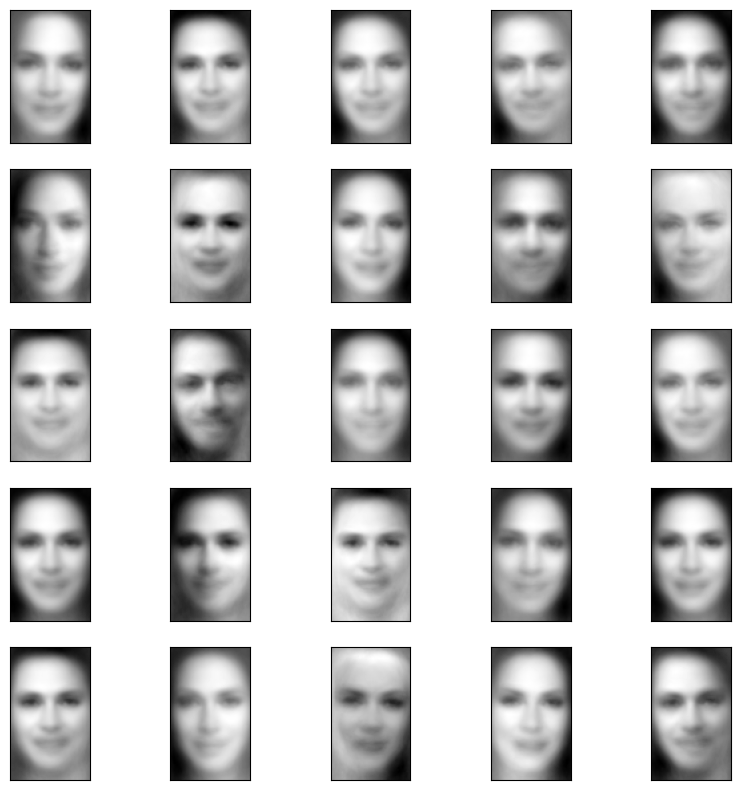

Sample results for k=25


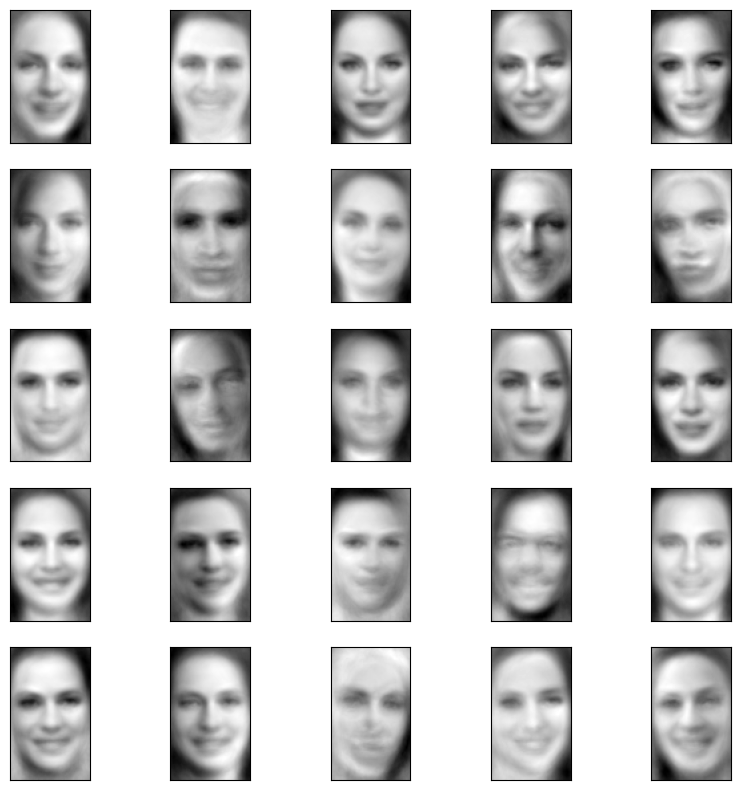

Sample results for k=125


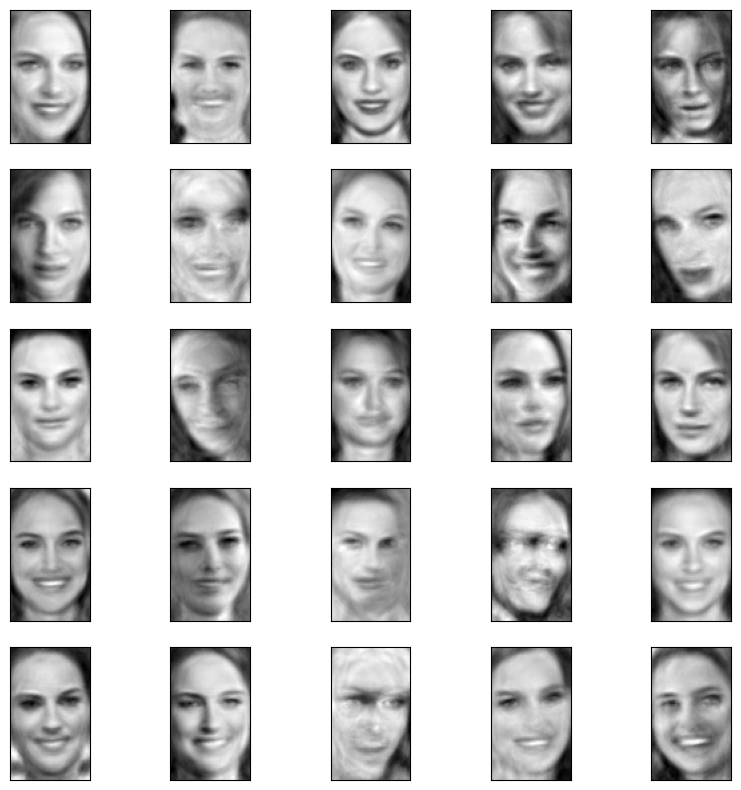

Sample results for k=625


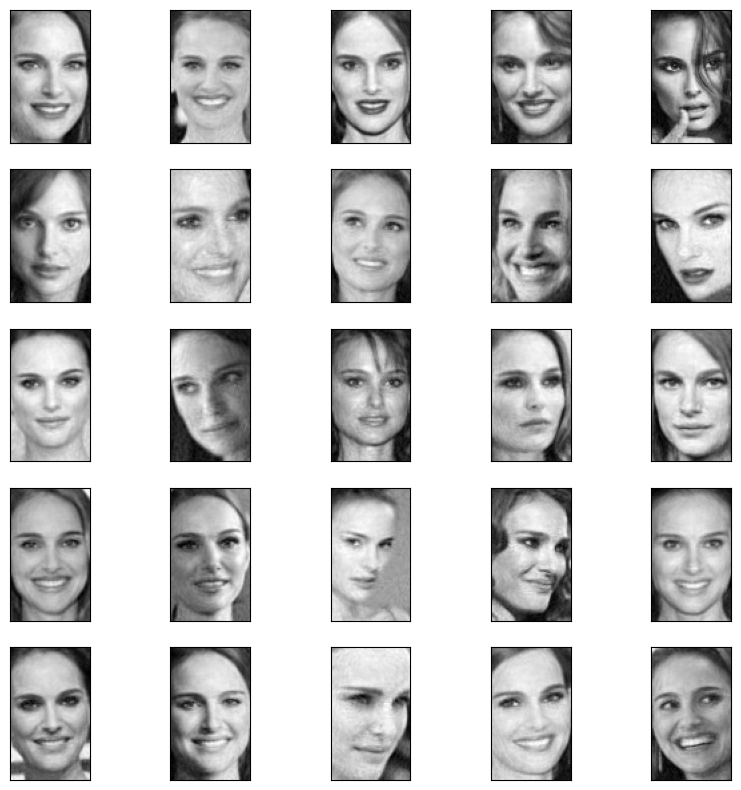

In [39]:
# TODO: Call sample_results on each k-dim reduction
for i in range(1, 5):
  print(f"Sample results for k={5**i}")
  sample_results(k_reductions[i-1])

You'll notice as k gets large, the images get closer and closer to the original. By k=625, the images are almost perfect! 

While they might look perfect, its important to remember **data is always lost using PCA reduction**. This is one of the major drawbacks of PCA reduction, Unless we use every distilled feature of our data *k=n*, we lose some amount of the original data.   

### 4.2 Computing MSE

Let's try to get a sense of how much data has been lost. One metric to do that is MSE!

####**Motivation Behind MSE**:

We say two images are "similar" to each other if, the saturation of each of their pixels are close together. That is for each pixel, we should reward pixels that are nearly the same, and penalize those that are very different.

MSE does this, by taking the average difference of each pixel, squaring the result to get distance between two pixels and accumulating this distance for each pixel & image.

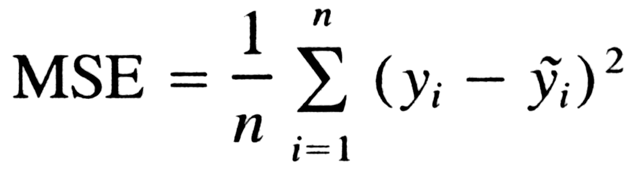

Here's a convenient link: [MSE](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.mean_squared_error)

In [40]:
# Compute the MSE between our images & each k-reduction of our images
from skimage.metrics import mean_squared_error
k_MSE = []
MSE = 0

for reduction in k_reductions:
  for i in range(num_samples):
    MSE += mean_squared_error(images[i], reduction[i])
  
  k_MSE.append(MSE / num_samples)
  MSE = 0

### 4.3. Computing SSIM


####**Motivation Behind SSIM**:

The problem with MSE is that there are a wide range of different alterations to an image can result in the same MSE. 

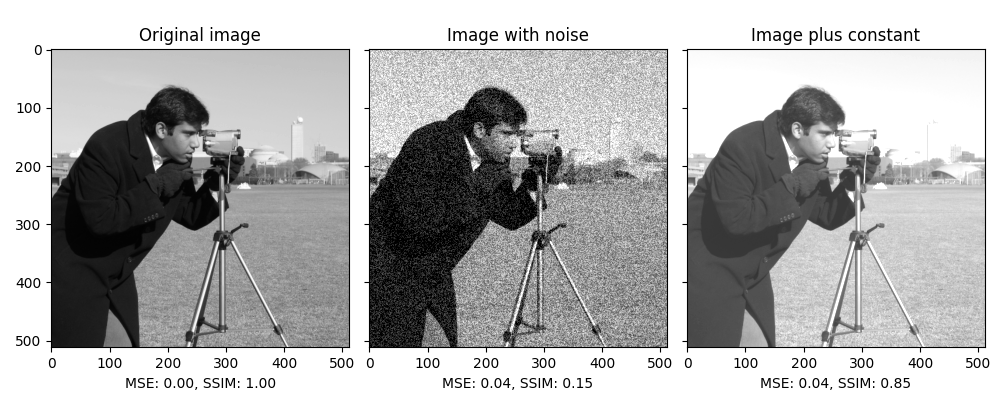

Notice how clear one alternation is to another. While MSE is able to capture the closeness of one image to another, it does not convey the structural integrity of the image.

For that we use the Structural Similarity Index Measure, or SSIM. This index takes into account the luminance, contrast and structural similarity of an image in a weighted product in order to calculate similarity. Scores are rated from 0-1, with 1 representing a perfect reconstructed image.

Here's another useful link: [SSIM](https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html#sphx-glr-auto-examples-transform-plot-ssim-py)

In [41]:
# Compute SSIM between the original images & each k-reduction of our images
from skimage.metrics import structural_similarity as ssim
k_SSIM = []
SSIM = 0

for reduction in k_reductions:
  for i in range(num_samples):
    SSIM += ssim(images[i], reduction[i])
  
  k_SSIM.append(SSIM / num_samples)
  SSIM = 0

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


[1176.0779822692464, 597.7341735714906, 216.2058254122636, 29.843964619217527]
[0.4934967069632442, 0.5806662921786466, 0.7187938020166174, 0.9127241239150592]


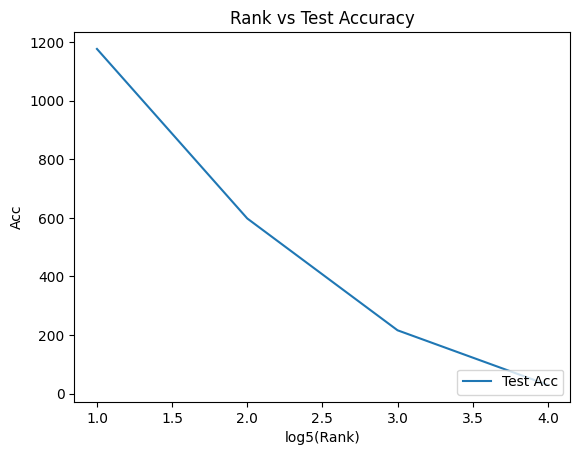

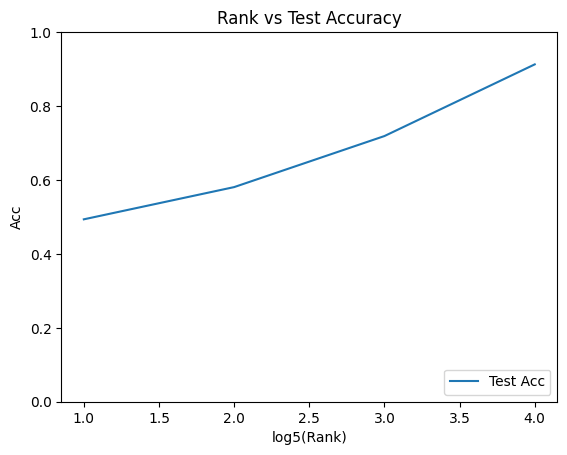

In [42]:
# Plot the results using matplotlib for MSE & SSIM

ranks = [1, 2, 3, 4]
print(k_MSE)
print(k_SSIM)

# Plotting MSE
plt.plot(ranks, k_MSE, label='Test Acc')
plt.xlabel('log5(Rank)')
plt.ylabel('Acc')
plt.legend(loc='lower right')
plt.title(f"Rank vs Test Accuracy")
plt.savefig('test_acc.png')
plt.show()

# Plotting SSIM
plt.plot(ranks, k_SSIM, label='Test Acc')
plt.xlabel('log5(Rank)')
plt.ylabel('Acc')
plt.legend(loc='lower right')
plt.title(f"Rank vs Test Accuracy")
plt.ylim(0, 1)
plt.savefig('test_acc.png')
plt.show()

### BONUS: Train Your Own ML-Model

An interesting use of PCA-reduction is to reduce high dimensional data to lower dimensions making it much more efficient to compute with. We can than train a machine learning model on the lower dimensionality data, and save on computing costs.

In the data file, each image should be attached with its corresponding label. Try training a ML model (using SVM, CNN, or whichever you'd like) on the k-dimensional representations of the data. 

How does the accuracy compare as k gets larger? 

In [43]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from numpy.linalg import svd

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from tensorflow.image import psnr
from tensorflow.math import reduce_sum



# Function to automate process of testing k
def run_k_model(k, training_images, training_labels, testing_images, testing_labels, avg_face):

  print(training_images.shape)
  print(training_labels.shape)
  print(testing_images.shape)
  print(testing_labels.shape)

  # Compute PCA for rank-k on cifar images
  U, S, Vt = compute_svd(k, training_images - avg_face)
  ktraining_images = (kPCA_eigenface(k, U, S, Vt, avg_face))
  ktraining_images = np.asarray([ktraining_images[:, i].reshape(h, w) for i in range(len(ktraining_images[0]))])
  print(ktraining_images.shape)

  # Compute Accuracy Metrics
  MSE, SSI, PSNR = 0, 0, 0
  num_samples = len(ktraining_images)
  conv_training_images = training_images.reshape(num_samples, h, w)
  
  PSNR = psnr(conv_training_images.reshape(num_samples, h, w, 1), ktraining_images.reshape(num_samples, h, w, 1), max_val=1)

  for i in range(num_samples):
    # print(f"Training: {conv_training_images[i].shape}")
    # print(f"ktraining_images: {ktraining_images[i].shape}")
    MSE += mean_squared_error(conv_training_images[i], ktraining_images[i])
    SSI += ssim(conv_training_images[i], ktraining_images[i], data_range=ktraining_images[i].max() - ktraining_images[i].min())
  
  PSNR = reduce_sum(PSNR) / num_samples
  MSE /= num_samples
  SSI /= num_samples

  validation_split = 0.8

  # Split between validation and training data
  kvalidation_images = ktraining_images[int(validation_split * num_samples):] 
  ktraining_images = ktraining_images[0:int(validation_split * num_samples)]
  kvalidation_labels = training_labels[int(validation_split * num_samples):] 
  ktraining_labels = training_labels[0: int(validation_split * num_samples)]

  # sample_results_reshaped(ktraining_images)

  # Defining Convolutional Model
  model = models.Sequential()
  model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(h, w, 1)))
  model.add(layers.Dropout(0.25))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Flatten())
  model.add(layers.Dense(200, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(17, activation='softmax'))

  # Compile and compute model
  model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
  history = model.fit(ktraining_images, ktraining_labels, epochs=25, validation_data=(kvalidation_images, kvalidation_labels))
  
  # Evaluate & display results
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.title(f"Epoch vs Accuracy for rank-{k}")
  plt.ylim(0, 1)
  plt.savefig(f'{k}rank-acc.png')
  plt.show()

  # print(testing_images.shape)
  # print(testing_labels.shape)

  testing_images = np.asarray([testing_images[i].reshape(h, w) for i in range(len(testing_labels))])

  test_loss, test_acc = model.evaluate(testing_images, testing_labels, verbose=2)
  print(f"Testing Loss for rank {k}: {test_loss}")
  print(f"Testing Accurracy for rank {k}: {test_acc}")
  print(f"Img Quality Metrics ~ MSE: {MSE} | SSI: {SSI} | PSNR: {PSNR}")

  return test_loss, test_acc, [MSE, SSI, PSNR]

In [ ]:
results = []
total_iterations = 11
for i in range(1):
  results.append(run_k_model(2**i, training_images, training_labels, testing_images, testing_labels, avg_face))